In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from skimage.io import imread
from torch.utils.data import DataLoader
import utils
from models import HumerusDataset, Rescale, NoneTransform, BaselineNN
import torch
from torch import nn
import torchvision
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [2]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [3]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split         Bone  \
24032  MURA-v1.1\train\XR_SHOULDER\patient01734\study...  train  XR_SHOULDER   
29291  MURA-v1.1\train\XR_WRIST\patient06501\study1_p...  train     XR_WRIST   
22889  MURA-v1.1\train\XR_SHOULDER\patient01368\study...  train  XR_SHOULDER   
6241   MURA-v1.1\train\XR_FINGER\patient03477\study1_...  train    XR_FINGER   
16537  MURA-v1.1\train\XR_HAND\patient10869\study1_ne...  train      XR_HAND   
21105  MURA-v1.1\train\XR_SHOULDER\patient00762\study...  train  XR_SHOULDER   
15295  MURA-v1.1\train\XR_HAND\patient10421\study1_ne...  train      XR_HAND   
16839  MURA-v1.1\train\XR_HAND\patient10976\study1_ne...  train      XR_HAND   
19858  MURA-v1.1\train\XR_SHOULDER\patient00365\study...  train  XR_SHOULDER   
31230  MURA-v1.1\train\XR_WRIST\patient07122\study1_p...  train     XR_WRIST   

            Patient       FolderName   Study     Label  
24032  patient01734  study1_negative  study1  negative  
29291  patient06501  study1_positive  study1  positive  
22889  patient01368  study1_positive  study1  positive  
6241   patient03477  study1_positive  study1  positive  
16537  patient10869  study1_negative  study1  negative  
21105  patient00762  study1_positive  study1  positive  
15295  patient10421  study1_negative  study1  negative  
16839  patient10976  study1_negative  study1  negative  
19858  patient00365  study1_positive  study1  positive  
31230  patient07122  study1_positive  study1  positive

We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


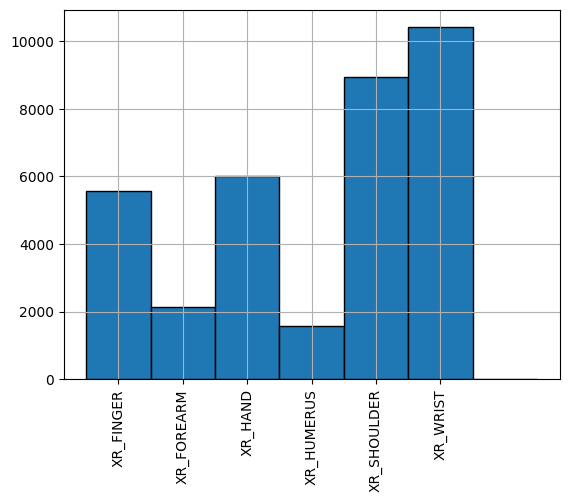

In [5]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [6]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient05789\study1_n...  train     XR_ELBOW   
1   MURA-v1.1\train\XR_FINGER\patient04258\study1_...  train    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient09529\study1...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient03551\study1_ne...  train      XR_HAND   
4   MURA-v1.1\train\XR_HUMERUS\patient03101\study1...  train   XR_HUMERUS   
5   MURA-v1.1\train\XR_SHOULDER\patient01986\study...  train  XR_SHOULDER   
6   MURA-v1.1\train\XR_WRIST\patient08595\study1_n...  train     XR_WRIST   
7   MURA-v1.1\train\XR_ELBOW\patient04910\study1_p...  train     XR_ELBOW   
8   MURA-v1.1\valid\XR_FINGER\patient11569\study1_...  valid    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient09151\study1...  train   XR_FOREARM   
10  MURA-v1.1\train\XR_HAND\patient09796\study1_po...  train      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02726\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient00222\study...  train  XR_SHOULDER   
13  MURA-v1.1\valid\XR_WRIST\patient11191\study1_p...  valid     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient05789  study1_negative  study1  negative  
1   patient04258  study1_negative  study1  negative  
2   patient09529  study1_negative  study1  negative  
3   patient03551  study1_negative  study1  negative  
4   patient03101  study1_negative  study1  negative  
5   patient01986  study1_negative  study1  negative  
6   patient08595  study1_negative  study1  negative  
7   patient04910  study1_positive  study1  positive  
8   patient11569  study1_positive  study1  positive  
9   patient09151  study1_positive  study1  positive  
10  patient09796  study1_positive  study1  positive  
11  patient02726  study1_positive  study1  positive  
12  patient00222  study1_positive  study1  positive  
13  patient11191  study1_positive  study1  positive

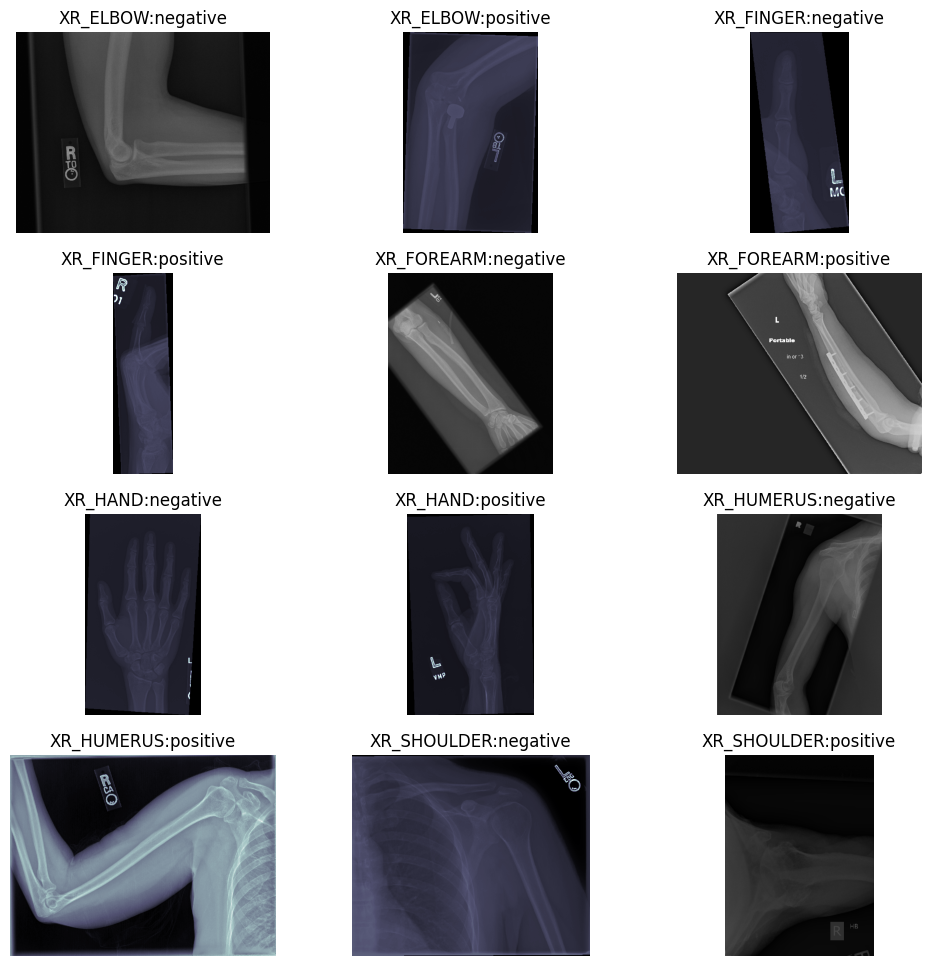

In [7]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [8]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
18067  MURA-v1.1\train\XR_HUMERUS\patient02935\study1...  train  XR_HUMERUS   
17980  MURA-v1.1\train\XR_HUMERUS\patient02895\study1...  train  XR_HUMERUS   
18096  MURA-v1.1\train\XR_HUMERUS\patient02947\study2...  train  XR_HUMERUS   
38574  MURA-v1.1\valid\XR_HUMERUS\patient11584\study1...  valid  XR_HUMERUS   
17458  MURA-v1.1\train\XR_HUMERUS\patient01344\study1...  train  XR_HUMERUS   
17549  MURA-v1.1\train\XR_HUMERUS\patient02706\study1...  train  XR_HUMERUS   
38571  MURA-v1.1\valid\XR_HUMERUS\patient11579\study1...  valid  XR_HUMERUS   
17853  MURA-v1.1\train\XR_HUMERUS\patient02841\study1...  train  XR_HUMERUS   
38716  MURA-v1.1\valid\XR_HUMERUS\patient11673\study1...  valid  XR_HUMERUS   
17627  MURA-v1.1\train\XR_HUMERUS\patient02740\study1...  train  XR_HUMERUS   

            Patient       FolderName   Study     Label  
18067  patient02935  study1_positive  study1  positive  
17980  patient02895  study1_positive  study1  positive  
18096  patient02947  study2_negative  study2  negative  
38574  patient11584  study1_negative  study1  negative  
17458  patient01344  study1_positive  study1  positive  
17549  patient02706  study1_positive  study1  positive  
38571  patient11579  study1_negative  study1  negative  
17853  patient02841  study1_positive  study1  positive  
38716  patient11673  study1_negative  study1  negative  
17627  patient02740  study1_positive  study1  positive

torch.Size([3, 256, 256]) 0
<class 'torch.Tensor'>


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


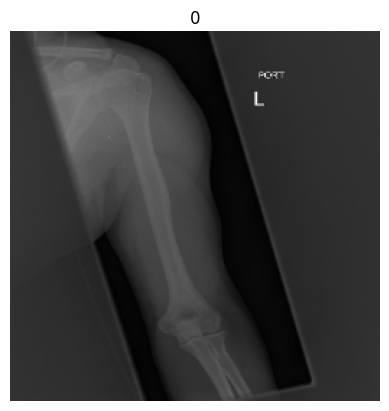

In [9]:
#DO NOT add transforms.ToTensor() to the transform list!
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256])
])

img, label = HumerusDataset(humerus_df,data_transforms).__getitem__(5)
#shape attributed evaluated at runtime depending on the dataset implementation

print(img.shape, label)
print(type(img))
utils.show_image_w_label(img, label)

In [10]:
BATCH_SIZE=32
transormation=torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
])

train_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='train'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='valid'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)


# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002532248B070>, <torch.utils.data.dataloader.DataLoader object at 0x000002532248A1D0>)
Length of train dataloader: 40 batches of 32
Length of test dataloader: 9 batches of 32


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [45]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=5):

    #put in training mode
    model.train()
    #reset model parameters
    model.reset_parameters()


    loss_history=[]
    for epoch in range(num_epochs):
        loss_per_epoch=0


        print(f"Epoch {epoch+1}/{num_epochs}")

        #batch computations
        for i, (inputs, labels) in enumerate(dataloader):
           # print("batch number",i)
            #inputs=inputs.view(inputs.shape[0],-1)
            outputs=model(inputs)
            #print(outputs.shape,outputs.dtype)
            #print(labels.shape,labels.dtype)
            labels=labels.type_as(outputs)

            #loss returns mean loss per batch unless specified otherwise
            batch_loss=loss_fn(outputs,labels)

            #add the batch_loss to epoch loss
            loss_per_epoch+=batch_loss.item()

            optimizer.zero_grad()
            #update parameters
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            #print(i, loss.item())
            # if i%8==0:
            #     print(f"Loss at iteration {i} is {round((loss_per_epoch/8),4)}")
            #     #loss_istory has acumulated the mean loss of 8 batches so we divide by 4 to get 
            #     # avg loss per batch
            #     loss_history.append(round((loss_per_epoch/8),4))
            #     loss_per_epoch=0
            if i % 9 == 0:
                print(f"Loss at batch {i} is {round((loss_per_epoch/9),4)}")


        print(f" Cumulative Loss at epoch {epoch+1} is {round((loss_per_epoch/len(dataloader)),4)}")
        loss_history.append(round((loss_per_epoch/len(dataloader)),4))
    return loss_history
    
@torch.no_grad()    
def evaluate(model, dataloader, loss_fn):
    model.eval()

    loss_history=[]
    
    for i, (inputs, labels) in enumerate(dataloader):
        inputs=inputs.view(inputs.shape[0],-1)
        outputs=model(inputs)
        labels=labels.type_as(outputs)
        loss=loss_fn(outputs,labels)
        loss_history.append(round(loss.item(),4))
    return loss_history

In [36]:
print(len(train_dataloader))    

40


In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
## explain why train_features_batch does not have the correct dimensions when applying shape????

In [46]:
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
loss_fn=torch.nn.BCELoss(reduction='mean')
model=BaselineNN(input_size=input_size, hidden_size=128, output_size=1)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=2)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn)




Input size: 196608
Epoch 1/2


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss at batch 0 is 0.076
Loss at batch 9 is 23.0384
Loss at batch 18 is 65.3061
Loss at batch 27 is 109.4573
Loss at batch 36 is 132.224
Loss at epoch 1 is 30.56
Epoch 2/2
Loss at batch 0 is 2.7052
Loss at batch 9 is 15.8111
Loss at batch 18 is 36.9796
Loss at batch 27 is 46.6766


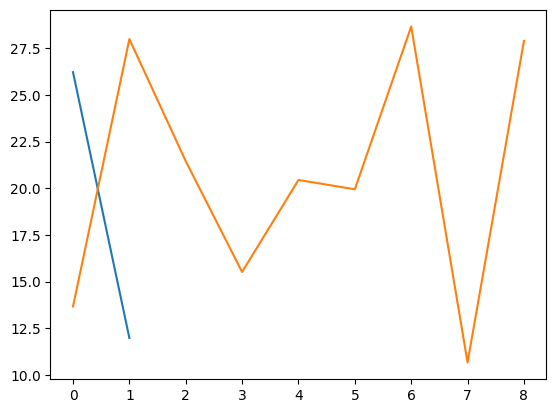

In [44]:
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')